# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [x] Add Lags for remaining districts
- [x] Replace `lagged` variables with `diff`
- [ ] Look-ahead values (e.g. 1 min 5 min 10 min 30 min) (tunable)
- [x] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add `LightGBM` model
- [ ] Benchmark accuracy, train-time, inference-time (in progress)
- [x] Add data from more than 1 days


In [1]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

from helper import cyclic_encode

In [2]:
df = pd.read_parquet("data/final/points_per_district_full.parquet.gzip")

In [3]:
df = (
    df.pivot_table(
        index="timestamp", columns="district_id", values="crowd", aggfunc="sum"
    )
    .ffill()
    .bfill()
    .astype(np.uint16)
    .sort_values(by="timestamp")
    .reset_index()
)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.head()

district_id,timestamp,Bedrijvenpark Noord-West,Botlek,Charlois,Delfshaven,Feijenoord,Hillegersberg-Schiebroek,Hoek van Holland,Hoogvliet,Kralingen-Crooswijk,...,Noord,Overschie,Pernis,Prins Alexander,Rivium,Rotterdam Centrum,Spaanse Polder,Vondelingenplaat,Waalhaven,Ĳsselmonde
0,2024-06-18 06:21:58,18,1,327,520,496,513,15,4,621,...,391,37,1,238,1,732,46,1,10,225
1,2024-06-18 06:23:00,18,1,328,520,497,512,15,4,621,...,390,37,1,238,1,730,46,1,10,225
2,2024-06-18 06:24:02,18,1,329,519,498,512,15,4,622,...,391,37,1,238,1,732,46,1,10,225
3,2024-06-18 06:25:04,18,1,329,519,499,512,15,4,621,...,391,37,1,238,1,734,46,1,10,225
4,2024-06-18 06:26:07,18,1,329,517,499,515,15,4,620,...,391,37,1,238,1,733,46,1,10,225


In [4]:
df.shape

(18245, 21)

## Feature Extraction

1. Binning
2. Time-related Features
   1. Extraction
      1. Hour
      2. Minute
      3. Day of week
   2. Cyclic Encoding
3. Lagged Features
   1. 1-10 Minutes
   2. 15 Minutes
   3. 30 Minutes
   4. 60 Minutes
4. Rolling Mean Features
   1. Mean
   2. Std
   3. Var
   4. Kurtosis
   5. Skewness
5. Exponential Smoothing Features
   1. 5 Minutes
   2. 10 Minutes
   3. 15 Minutes
   4. 30 Minutes
   5. 60 Minutes


##### Binning


In [5]:
target_district = "Rotterdam Centrum"
target_column_name = f'{target_district.replace(" ", "_")}_c_lvl'

mean_crowd = df[target_district].mean()
std_crowd = df[target_district].std()

# Define bins based on mean and standard deviation
# bins = [
#     float("-inf"),
#     mean_crowd - 1.0 * std_crowd,
#     mean_crowd - 0.4 * std_crowd,
#     mean_crowd + 0.4 * std_crowd,
#     mean_crowd + 1.0 * std_crowd,
#     float("inf"),
# ]

bins = [
    float("-inf"),
    mean_crowd - 0.55 * std_crowd,
    mean_crowd + 0.55 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [6]:
df[target_column_name] = pd.cut(
    df[target_district],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(np.uint8)

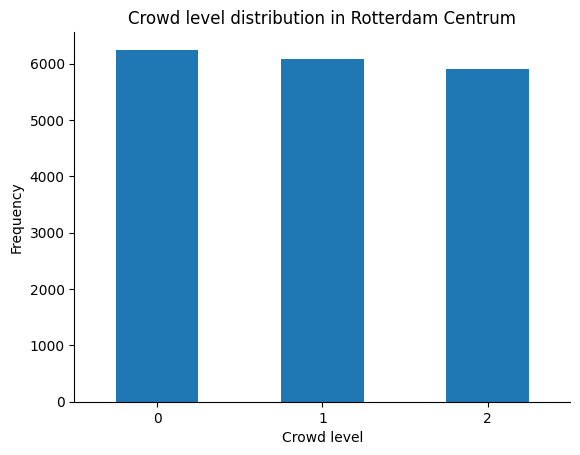

In [7]:
df[target_column_name].value_counts().sort_index().plot(
    kind="bar",
    rot=0,
    xlabel="Crowd level",
    ylabel="Frequency",
    title=f"Crowd level distribution in {target_district}",
)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

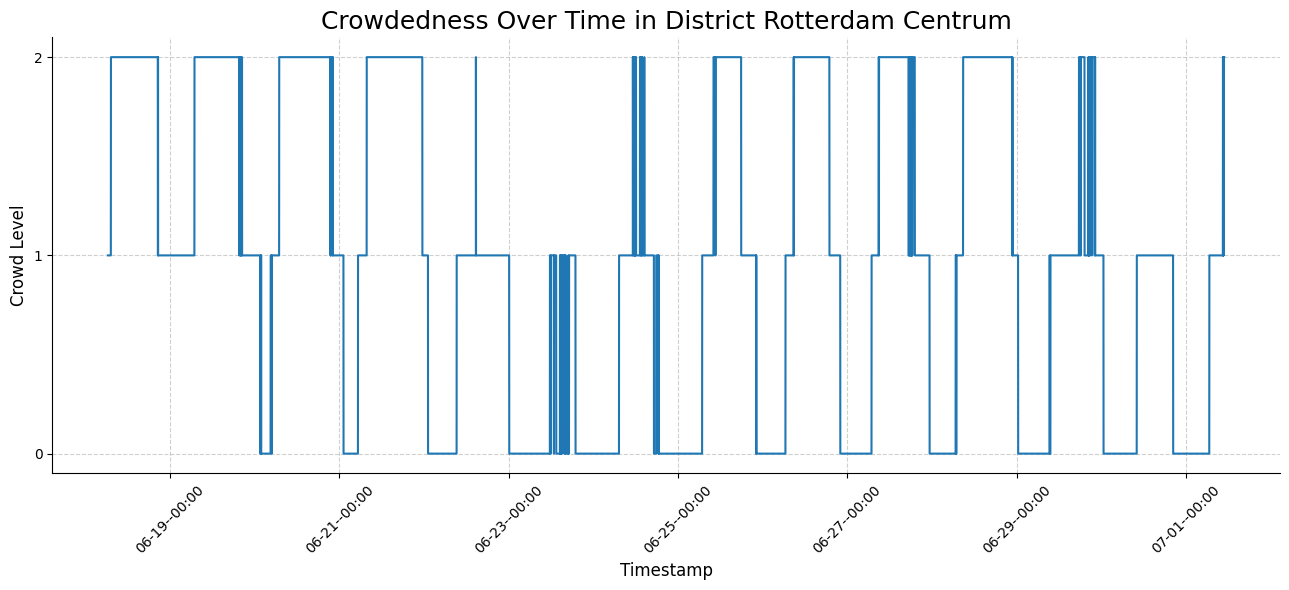

In [8]:
_, ax = plt.subplots(figsize=(13, 6))


ax.plot(
    df["timestamp"],
    df[target_column_name],
    linestyle="-",
    linewidth=1.5,
)

ax.set_title(f"Crowdedness Over Time in District {target_district}", fontsize=18)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Crowd Level", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d--%H:%M"))

plt.xticks(rotation=45)
plt.yticks(df[target_column_name].unique())
plt.tight_layout()
# plt.savefig(f"figures/Crowdedness (Binned) {target_district}.png", dpi=150)
plt.show()

Time-related Feature Extraction


In [9]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype("category"),
}

Lagged and Rolling Feature Extraction


In [10]:
lagged_features = {}
rolling_features = {}
exp_smoothing_features = {}
windows = [5, 10, 15, 30] + [60 * i for i in range(1, 7)] + [60 * 24]

for district in df.columns[1:-1]:
    lagged_features.update(
        {
            f"{district.replace(' ', '_')}_lag_{i}": df[district].shift(i).diff()
            for i in list(range(1, 11)) + [15, 30, 60]
        }
    )

    rolling_features.update(
        {
            f"{district.replace(' ', '_')}_rolling_{stat}_{window}": getattr(
                df[target_district].rolling(window=window), stat
            )()
            for window in windows
            for stat in ["mean", "std", "var", "skew", "kurt"]
        }
    )

    exp_smoothing_features.update(
        {
            f"{district.replace(' ', '_')}_ema_{window}": df[target_district]
            .ewm(span=window, adjust=True)
            .mean()
            for window in windows
        }
    )

In [11]:
lagged_df = (
    pd.concat(
        [
            # After Feature Extraction we can drop the original target column
            df.drop(columns=target_district),
            pd.DataFrame(lagged_features),
            pd.DataFrame(rolling_features),
            pd.DataFrame(exp_smoothing_features),
            pd.DataFrame(time_related_features),
        ],
        axis=1,
    )
    .set_index("timestamp")
    .dropna()
)

# lagged_df = cyclic_encode(lagged_df, "minute", 60)
# lagged_df = cyclic_encode(lagged_df, "hour", 24)
# lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

#### Data Splitting


In [12]:
X = lagged_df.drop(columns=target_column_name)
y = lagged_df[target_column_name]

X.shape, y.shape

((16806, 1603), (16806,))

#### Correlation Analysis
(Still in Progress)


In [13]:
# cm = X.corr(method="kendall", numeric_only=True).abs()
# upper = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))

# high_corr = [col for col in upper.columns if any(upper[col] > 0.8)]
# X.drop(columns=high_corr, inplace=True)

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [14]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, shuffle=False
)

In [15]:
print(
    f"TRAIN: {X_train.shape}, {y_train.shape}, \nTEST: {X_test.shape}, {y_test.shape}"
)

TRAIN: (10083, 1603), (10083,), 
TEST: (6723, 1603), (6723,)


#### Pipeline Construction


In [16]:
num_features = X_train.select_dtypes(include=np.number).columns.tolist()

In [17]:
def build_pipe(clf):
    preprocessor = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), num_features),
            ("one-hot", OneHotEncoder(handle_unknown="ignore"), ["is_weekend"]),
        ],
        remainder="passthrough",
    )

    # Define the pipeline
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", clf),
        ]
    )


clf = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    gamma=0,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=10,
    reg_lambda=0.5,
    n_jobs=-1,
    random_state=42,
)

pipeline = build_pipe(clf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Bedrijvenpark Noord-West',
                                                   'Botlek', 'Charlois',
                                                   'Delfshaven', 'Feijenoord',
                                                   'Hillegersberg-Schiebroek',
                                                   'Hoek van Holland',
                                                   'Hoogvliet',
                                                   'Kralingen-Crooswijk',
                                                   'Nieuw Mathenesse', 'Noord',
                                                   'Overschie', 'Pernis',
                                                   'Prins Alexander', 'Rivium',
                                                   'Spaanse Pol...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1, num_class=5,
                               num_parallel_tree=None, ...))])

##### Grid Search


In [ ]:
param_grid = {
    "classifier__max_depth": [2, 5, 10],
    "classifier__learning_rate": [0.05, 0.1, 0.2],
    "classifier__colsample_bytree": [0.7, 0.8],
    "classifier__reg_lambda": [0.3, 0.5, 0.7],
}

In [18]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}

In [19]:
for i, (train_index, test_index) in enumerate(ts_cv.split(X_train)):
    print(f"Fold {i+1}:")
    print(f"Value Counts: {y_train.iloc[train_index].value_counts()}")

Fold 1:
Value Counts: Rotterdam_Centrum_c_lvl
2    1048
1     472
0     163
Name: count, dtype: int64
Fold 2:
Value Counts: Rotterdam_Centrum_c_lvl
2    2163
1     799
0     401
Name: count, dtype: int64
Fold 3:
Value Counts: Rotterdam_Centrum_c_lvl
2    2479
1    1693
0     871
Name: count, dtype: int64
Fold 4:
Value Counts: Rotterdam_Centrum_c_lvl
2    2479
0    2213
1    2031
Name: count, dtype: int64
Fold 5:
Value Counts: Rotterdam_Centrum_c_lvl
0    3150
1    2717
2    2536
Name: count, dtype: int64


No need to run Grid Search - Results are shown below

Skip the next 3 cells

In [ ]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="f1_micro",
    n_jobs=1,
    verbose=1,
    error_score="raise",
)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

In [ ]:
for key, value in grid_search.cv_results_.items():
    (
        print(
            f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

##### Best Model Parameters - Grid Search Results 
- colsample_bytree: 0.7
- learning_rate: 0.05
- max_depth: 10
- reg_lambda: 0.5

In [20]:
cv_result = cross_validate(
    pipeline, X_train, y_train, cv=ts_cv, scoring=scoring, error_score="raise"
)

In [21]:
for key, value in cv_result.items():
    (
        print(
            f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

Test Accuracy: 0.991 ± 0.005
Test F1 Micro: 0.991 ± 0.005


In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Bedrijvenpark Noord-West',
                                                   'Botlek', 'Charlois',
                                                   'Delfshaven', 'Feijenoord',
                                                   'Hillegersberg-Schiebroek',
                                                   'Hoek van Holland',
                                                   'Hoogvliet',
                                                   'Kralingen-Crooswijk',
                                                   'Nieuw Mathenesse', 'Noord',
                                                   'Overschie', 'Pernis',
                                                   'Prins Alexander', 'Rivium',
                                                   'Spaanse Pol...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1, num_class=5,
                               num_parallel_tree=None, ...))])

## **Skip the next 2 cells**

**_Experimental state below_**


In [23]:
cv_results_test = cross_validate(
    pipeline,
    X_test,
    y_test,
    cv=ts_cv,
    scoring=scoring,
    error_score="raise",
)

In [24]:
for key, value in cv_results_test.items():
    (
        print(
            f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

Test Accuracy: 0.985 ± 0.007
Test F1 Micro: 0.985 ± 0.007


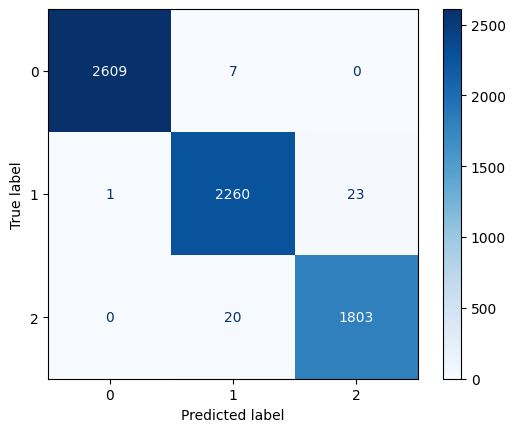

In [25]:
y_pred = pipeline.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap="Blues")

In [26]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["low", "medium", "high"],
    )
)

              precision    recall  f1-score   support

         low      1.000     0.997     0.998      2616
      medium      0.988     0.989     0.989      2284
        high      0.987     0.989     0.988      1823

    accuracy                          0.992      6723
   macro avg      0.992     0.992     0.992      6723
weighted avg      0.992     0.992     0.992      6723

